In [695]:
#pip install pyswarms


In [696]:
from datetime import date
import random

import seaborn as sns

import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt

from numpy.fft import fft, ifft
import numpy as np
from numpy import log, sqrt, exp


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy.stats as stats
from scipy.stats import probplot, laplace, norm, t, poisson
from scipy.linalg import solve_banded
from scipy.optimize import minimize, differential_evolution
from scipy.integrate import quad
from scipy.special import roots_laguerre


import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

import pymc as pm
import arviz as az

from tensorflow import keras
#from tensorflow.keras.utils import plot_model

import pyswarms as ps

######################################
#from pmdarima import auto_arima
#from diptest import diptest

In [697]:
class OptionAnalysis:
    def __init__(self) -> None:
        pass


    def plot_pricing_error_vs_maturity(self, org_records):
        # Sort by maturity
        org_records.sort_values(by='Maturity', inplace=True)

        # Calculate pricing differences
        org_records['diff'] = org_records['cal_price'] - org_records['obs_price']

        # Separate call and put records
        calls = org_records[org_records['option_type'] == 'call'].copy()
        puts  = org_records[org_records['option_type'] == 'put'].copy()

        # Filter the relevant columns and rename for clarity
        calls_df = calls[['strike', 'Maturity', 'diff']].rename(columns={'diff': 'call_diff'})
        puts_df  = puts[['strike', 'Maturity', 'diff']].rename(columns={'diff': 'put_diff'})

        # Merge on strike and Maturity
        records = pd.merge(calls_df, puts_df, on=['strike', 'Maturity'], how='inner')

        fig, axs = plt.subplots(2, figsize=(14, 10))
        fig.suptitle("Model Pricing Error vs Maturity", fontsize=16)

        # --- CALL PRICING ERROR ---
        ax_call = axs[0]
        ax_call.scatter(records['Maturity'], records['call_diff'], color='blue', label='Call Pricing Error')
        ax_call.axhline(y=0, color='gray', linestyle='--')

        for i in range(len(records)):
            label = f"Strike: {records['strike'][i]}"
            ax_call.annotate(label,
                             (records['Maturity'][i], records['call_diff'][i]),
                             textcoords="offset points", xytext=(0, 6),
                             ha='center', fontsize=8)

        ax_call.set_title("Call Option Pricing Error vs Maturity")
        ax_call.set_xlabel("Maturity")
        ax_call.set_ylabel("Model - Market Call Price")
        ax_call.set_ylim(-20, 20)
        ax_call.grid(True)
        ax_call.legend()

        # --- PUT PRICING ERROR ---
        ax_put = axs[1]
        ax_put.scatter(records['Maturity'], records['put_diff'], color='green', label='Put Pricing Error')
        ax_put.axhline(y=0, color='gray', linestyle='--')

        for i in range(len(records)):
            label = f"Strike: {records['strike'][i]}"
            ax_put.annotate(label,
                            (records['Maturity'][i], records['put_diff'][i]),
                            textcoords="offset points", xytext=(0, 6),
                            ha='center', fontsize=8)

        ax_put.set_title("Put Option Pricing Error vs Maturity")
        ax_put.set_xlabel("Maturity")
        ax_put.set_ylabel("Model - Market Put Price")
        ax_put.set_ylim(-20, 20)
        ax_put.grid(True)
        ax_put.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [698]:
class Bayesian_PP:
    def __init__(self):
        self.log_returns = None
        self.df=None

        self.mu_prior = None
        self.sigma_prior = None
        self.mu_j_prior = None
        self.sigma_j_prior = None
        self.lamda_j_prior = None

        self.mu_samples = None
        self.sigma_samples = None
        self.mu_j_samples = None
        self.sigma_j_samples = None
        self.lamda_j_samples = None

    def log_return(self, df):
        self.df=df
        df['log_return'] = np.log(self.df / self.df.shift(1))
        self.log_returns = df['log_return'].dropna()

        '''GBM'''

        sorted = self.log_returns.sort_index()

        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.25)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 1.5 * iqr
        upper_bound = qv2 + 1.5 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        log_returns_values = filtered_sorted.values

        mu, sigma = stats.norm.fit(log_returns_values)

        # Compute annualized values
        mu_annual = mu * 252
        sigma_annual = sigma * np.sqrt(252)

        mu_daily_rounded, sigma_daily_rounded, mu_annual_rounded, sigma_annual_rounded  = round(mu * 100, 2), round(sigma * 100, 2), round(mu_annual * 100, 2), round(sigma_annual * 100, 2)
        print(f"Daily mu (sigma) = {mu_daily_rounded}% ± {sigma_daily_rounded}%")
        print(f"Annual mu (sigma) = {mu_annual_rounded}% ± {sigma_annual_rounded}%")

        # Setup subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

        # ─────────────────────────────
        # 1️⃣ Time Series Plot
        axs[0].plot(self.log_returns, label='Log Returns')
        axs[0].axhline(mu - 1*sigma, color='b', linestyle='--', label=f'μ - 1σ = {mu - 3*sigma:.4f}')
        axs[0].axhline(mu + 1*sigma, color='b', linestyle='--', label=f'μ + 1σ = {mu + 3*sigma:.4f}')
        axs[0].set_title('Daily Log Returns (Time Series)', fontsize=14)
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Log Return')
        axs[0].legend()
        axs[0].grid(True)

        # ─────────────────────────────
        # 2️⃣ Histogram + Gaussian Fit
        x = np.linspace(self.log_returns.min(), self.log_returns.max(), 1000)
        pdf = stats.norm.pdf(x, mu, sigma)

        axs[1].hist(log_returns_values, bins=50, density=True, alpha=0.6, edgecolor='k', label='Histogram')
        axs[1].plot(x, pdf, 'r-', label=f'Gaussian Fit\nμ={mu:.4f}, σ={sigma:.4f}')
        axs[1].axvline(mu - 1*sigma, color='b', linestyle='--', label=f'μ - 1σ = {mu - 3*sigma:.4f}')
        axs[1].axvline(mu + 1*sigma, color='b', linestyle='--', label=f'μ + 1σ = {mu + 3*sigma:.4f}')
        axs[1].set_title('Log Returns Distribution & Gaussian Fit', fontsize=14)
        axs[1].set_xlabel('Log Return')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].grid(True)

        # ─────────────────────────────
        # 3️⃣ Q-Q Plot
        stats.probplot(log_returns_values, dist="norm", plot=axs[2])
        axs[2].get_lines()[1].set_color('red')  # Line of best fit
        axs[2].set_title('Q-Q Plot of Log Returns', fontsize=14)
        axs[2].grid(True)

        # Show all
        plt.show()

        self.mu_prior = mu_annual
        self.sigma_prior = sigma_annual

        ''' Merton'''

        threshold = 3 * sigma
        #Create binary jump indicator
        jump_indicator = (np.abs(self.log_returns - mu) > threshold).astype(int)

        #Resample by year and count jumps
        yearly_jump_counts = jump_indicator.resample('YE').sum()
        yearly_jump_counts.index = yearly_jump_counts.index.year

        sorted = yearly_jump_counts.sort_index()

        #Estimate λ (Poisson mean)
        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.0)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 0 * iqr
        upper_bound = qv2 + 0 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        yearly_jump_counts_values = filtered_sorted.values

        lambda_j = yearly_jump_counts_values.mean()

        ###
        # Theoretical quantiles from Poisson
        n = len(yearly_jump_counts_values)
        quantiles = np.linspace(0.01, 0.99, n)
        percentiles = np.quantile(yearly_jump_counts_values, quantiles)
        theoretical_q = stats.poisson.ppf(quantiles, mu=lambda_j)

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # --- Plot 1: Histogram with Poisson PMF ---
        axs[0].hist(yearly_jump_counts_values, bins=range(int(max(yearly_jump_counts_values))+2),
                    density=True, alpha=0.6, edgecolor='k', label='Observed')

        x = np.arange(0, max(yearly_jump_counts_values)+1)
        pmf = stats.poisson.pmf(x, mu=lambda_j)
        axs[0].plot(x, pmf, 'ro-', label=f'Poisson PMF (λ={lambda_j:.2f})')

        axs[0].set_title("Poisson Fit to Yearly Jump Counts")
        axs[0].set_xlabel("Jump Count per Year")
        axs[0].set_ylabel("Probability")
        axs[0].legend()
        axs[0].grid(True)

        # --- Plot 2: Q-Q Plot ---
        axs[1].plot(theoretical_q, percentiles, 'bo', label='Empirical vs Poisson')
        axs[1].plot([0, max(theoretical_q.max(), yearly_jump_counts_values.max())],
                    [0, max(theoretical_q.max(), yearly_jump_counts_values.max())],
                    'r--', label='Ideal Fit (y = x)')

        axs[1].set_title("Q-Q Plot: Empirical vs Poisson Quantiles")
        axs[1].set_xlabel("Theoretical Quantiles (Poisson)")
        axs[1].set_ylabel("Empirical Quantiles (Observed)")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Estimate mu_J and sigma_J (jump size stats)
        jump_sizes = self.log_returns.loc[np.abs(self.log_returns - mu) > threshold].dropna() #Extract jump sizes

        sorted = jump_sizes.sort_index()

        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.25)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 2.5 * iqr
        upper_bound = qv2 + 2.5 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        jump_sizes_values = filtered_sorted.values

        # Fit normal distribution
        mu_J, sigma_J = norm.fit(jump_sizes_values)

        # Create subplots: 1 row, 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Histogram with fitted normal curve
        axs[0].hist(jump_sizes_values, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
        xmin, xmax = axs[0].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_J, sigma_J)
        axs[0].plot(x, p, 'r', linewidth=2)
        axs[0].set_title("Histogram of Jump Sizes with Fitted Normal Curve")
        axs[0].set_xlabel("Jump Size")
        axs[0].set_ylabel("Density")
        axs[0].grid(True)
        # Add mu_J and sigma_J to the plot
        textstr = f"$\\mu_J$ = {mu_J:.4f}\n$\\sigma_J$ = {sigma_J:.4f}"
        axs[0].text(0.95, 0.95, textstr,
                    transform=axs[0].transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.8))

        # Q-Q plot
        probplot(jump_sizes_values, dist="norm", sparams=(mu_J, sigma_J), plot=axs[1])
        axs[1].set_title("Q-Q Plot vs Fitted Normal")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        self.mu_j_prior = mu_J
        self.sigma_j_prior = sigma_J
        self.lamda_j_prior = lambda_j

        return self.mu_prior, self.sigma_prior, self.mu_j_prior, self.sigma_j_prior, self.lamda_j_prior


    """Fit a Bayesian model to estimate mu and sigma."""
    def fit_bayesian_model(self, nsample, nburn, nchain):

        with pm.Model() as model:

            mu_prior = self.mu_prior
            sigma_prior = self.sigma_prior

            # Prior for mu
            mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)

            #Prior for sigma
            #sigma_squared = pm.InverseGamma("sigma_squared", alpha=2, beta=self.sigma_prior)
            #igma = pm.Deterministic("sigma", pm.math.sqrt(sigma_squared))

            sigma = pm.HalfNormal("sigma", sigma=sigma_prior)

            # Likelihood (observed log returns)
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.log_returns)

            # Sampling (using Metropolis algorithm)
            step = pm.Metropolis()
            trace = pm.sample(nsample+nburn, step=step, tune=nburn, chains=nchain, return_inferencedata=True, random_seed=42)

        az.plot_trace(trace, var_names=["mu", "sigma"])
        plt.tight_layout()
        plt.show()
        az.plot_autocorr(trace, var_names=["mu", "sigma"])
        plt.tight_layout()
        plt.show()
        summary = az.summary(trace, var_names=["mu", "sigma"], round_to=4)
        print(summary)

        # Extract posterior samples
        mu_samples = trace.posterior['mu'].values.flatten()
        sigma_samples = trace.posterior['sigma'].values.flatten()

        self.mu_samples = mu_samples * 252
        self.sigma_samples = self.sigma_samples * np.sqrt (252)

        return self.mu_samples, self.sigma_samples



In [699]:
class loss_function:
    def __init__(self, df, column, business_days, npath, rfr, risk_neutral, strike, option_type, obs_price):
        self.df = df
        self.column = column
        self.business_days = business_days
        self.npath = npath
        self.rfr = rfr
        self.risk_neutral = risk_neutral
        self.strike = strike
        self.option_type = option_type
        self.obs_price = obs_price
        self.maturity = business_days / 252

    def heston_pso_minimizer(self, bounds, iterr):

        def objective_function(params):
            # Ensure params is 5D
            if params.ndim == 1:
                params = params.reshape(1, -1)

            loss_values = []  # Store loss for each particle
            for particle in params:
                rho, kappa, sigma_sigma, theta, inst_vol = particle
                loss_option_price = 0
                for i in range(len(self.business_days)):

                    ''' -----------------------------------------------'''

                    model_option_price = heston_options_value(self.df[self.column].iloc[-1], self.strike[i], self.maturity[i], self.rfr, rho, kappa, sigma_sigma, self.rfr, theta, inst_vol, self.option_type[i]).semi_analytical()

                    ''' -----------------------------------------------'''
                    '''
                    # Simulate future prices and calculate option payoff
                    simulated_prices, volatility = Stochastic_prices_MC(self.df[self.column], self.business_days[i], self.df[self.column].iloc[-1], 1, self.rfr, self.risk_neutral).simulate_future_prices_Heston_calibration(rho, kappa, sigma_sigma, self.rfr, theta, inst_vol)
                    if self.option_type[i] == 'call':
                        payoff = np.maximum(simulated_prices[:, -1] - self.strike[i], 0)
                    else:
                        payoff = np.maximum(self.strike[i] - simulated_prices[:, -1], 0)
                    model_option_price = np.exp(-self.rfr * self.maturity[i]) * np.mean(payoff)
                    '''
                    ''' -----------------------------------------------'''

                    loss_option_price += (model_option_price - self.obs_price[i])**2

                loss_values.append(loss_option_price)  # Add loss for this particle

            if len(loss_values) == 1:
                return loss_values[0]
            else:
                return np.array(loss_values)  # Return array of losses for all particles

        # -----------------------------
        # 2. PSO Setup
        # -----------------------------
        dimensions = len(bounds[0])
        n_particles = 20
        iters = iterr

        # PSO parameters
        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

        # Initialize optimizer
        optimizer = ps.single.GlobalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=options,
            bounds=bounds
        )

        # -----------------------------
        # 3. Custom PSO loop with position & cost history
        # -----------------------------
        pos_history = []
        cost_history = []

        optimizer.reset()

        for _ in range(iters):
            cost, pos = optimizer.optimize(objective_function, iters=1, verbose=False)
            pos_history.append(optimizer.swarm.position.copy())
            cost_history.append(cost)

        pos_history = np.array(pos_history)  # (iters, n_particles, dimensions)
        cost_history = np.array(cost_history)

        # -----------------------------
        # 4. Plotting
        # -----------------------------
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # 4a. Particle trajectories (2D projection)
        for p_id in range(3):  # Pick 3 particles
            traj = pos_history[:, p_id, :]
            axs[0].plot(traj[:, 0], traj[:, 1], marker='o', label=f"Particle {p_id}")

        axs[0].set_title("Particle Trajectories (2D Projection)")
        axs[0].set_xlabel("Dimension 0")
        axs[0].set_ylabel("Dimension 1")
        axs[0].legend()
        axs[0].grid(True)

        # 4b. Cost convergence plot
        axs[1].plot(cost_history, color='purple')
        axs[1].set_title("PSO Convergence")
        axs[1].set_xlabel("Iteration")
        axs[1].set_ylabel("Best Cost")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        print (pos)
        return pos  # Return the best parameters

In [700]:
class binomial_tree:

    def __init__(self, df, nfuture, last_price ,npath, rfr, risk_neutral = True):
        self.nfuture = nfuture
        self.df = df
        self.rfr = rfr
        self.risk_neutral = risk_neutral
        self.npath = npath
        self.last_price = last_price
        self.simulated_prices = None

        self.u = None
        self.d = None
        self.p = None

    def simulate_future_prices_btree(self, mu_sample, sigma_sample):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        u = np.exp(sigma_sample * np.sqrt(dt))
        d = 1 / u

        for ii in range(self.npath):
                for t in range(1, self.nfuture + 1):
                    #Analytical solution COX-Ross-Rubinstein model
                    ur = np.random.rand()

                    if self.risk_neutral:
                        p = (np.exp(self.rfr * dt) - d) / (u - d)
                        move = ur < p  # True = up, False = down  #move = np.random.binomial(1, p) through bernoulli
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (u if move else d)
                    else:
                        p = (np.exp(mu_sample * dt) - d) / (u - d)
                        move = ur < p  # True = up, False = down     #move = np.random.binomial(1, p) through bernoulli
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (u if move else d)

        self.simulated_prices = simulated_prices
        self.u = u
        self.d = d
        self.p = p
        return simulated_prices

    def price_european_options(self, S_maturity, maturity_years, strike, option_type, records):
        # Initialize empty arrays for option prices
        cal_price = np.zeros(len(maturity_years))
        mean_S_maturity = np.zeros(len(maturity_years))

        u = self.u
        d = self.d
        p = self.p
        dt = 1 / 252  # Daily time step

        for j in range(len(maturity_years)):
            n_steps = len(S_maturity[j]) - 1  # assumes full tree layer

            # Get payoffs at maturity
            if option_type[j] == 'call':
                payoff = np.maximum(S_maturity[j] - strike[j], 0)
            else:
                payoff = np.maximum(strike[j] - S_maturity[j], 0)

            # Work backward through the tree
            for step in range(n_steps, 0, -1):
                payoff = np.exp(-self.rfr * dt) * (p * payoff[1:] + (1 - p) * payoff[:-1])

            # Final result at the root of the tree
            cal_price[j] = payoff[0]
            mean_S_maturity[j] = np.mean(S_maturity[j])

        # Update the records DataFrame with the prices and mean of the maturity values
        records['Maturity'] = maturity_years
        records['Maturity'] = (records['Maturity'] * 100).astype(int) / 100.0
        records['cal_price'] = cal_price
        records['Mean S_maturity'] = mean_S_maturity

        return records

In [701]:
class Stochastic_prices_MC:
    def __init__(self, df, nfuture, last_price, npath, rfr, risk_neutral = True):
        self.nfuture = nfuture
        self.df = df
        self.rfr = rfr
        self.risk_neutral = risk_neutral
        self.npath = npath
        self.last_price = last_price
        self.simulated_prices = None
        self.volatility = None


    def simulate_future_prices_Heston_calibration(self, rho, kappa, sigma_sigma, mu_sample, sigma_sample, inst_vol):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))
        volatility = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths
        volatility[:, 0] = inst_vol

        dt = 1 / 252  # Daily time step

        for ii in range(self.npath):
            np.random.seed(15)
            z1 = np.random.normal(0, 1, self.nfuture)
            z2 = np.random.normal(0, 1, self.nfuture)
            w1 = z1
            w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
            for t in range(1, self.nfuture + 1):
                 ##Euler-Maruyama Discretization
                 if self.risk_neutral:
                      volatility[ii, t] = np.maximum(volatility[ii, t-1] + kappa * (sigma_sample - volatility[ii, t-1]) * dt + sigma_sigma * np.sqrt(volatility[ii, t-1] * dt) * w2[ii-1], 0)
                      simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * volatility[ii, t-1]) * dt + np.sqrt( volatility[ii, t-1] * dt) * w1[ii-1])
                 else:
                      volatility[ii, t] = np.maximum(volatility[ii, t-1] + kappa * (sigma_sample - volatility[ii, t-1]) * dt + sigma_sigma * np.sqrt(volatility[ii, t-1] * dt) * w2[ii-1], 0)
                      simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((mu_sample - 0.5 * volatility[ii, t-1]) * dt + np.sqrt( volatility[ii, t-1] * dt) * w1[ii-1])

        self.simulated_prices = simulated_prices
        self.volatility = volatility
        return simulated_prices, volatility

    def simulate_future_prices_Heston(self, rho, kappa, sigma_sigma, mu_sample, sigma_sample, inst_vol):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))
        volatility = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths
        volatility[:, 0] = inst_vol

        dt = 1 / 252  # Daily time step

        for ii in range(self.npath):
            for t in range(1, self.nfuture + 1):
                 ##Euler-Maruyama Discretization
                 z1 = np.random.normal(0, 1, 1)
                 z2 = np.random.normal(0, 1, 1)
                 w1 = z1
                 w2 = rho * z1 + np.sqrt(1 - rho**2) * z2

                 if self.risk_neutral:
                      volatility[ii, t] = np.maximum(volatility[ii, t-1] + kappa * (sigma_sample - volatility[ii, t-1]) * dt + sigma_sigma * np.sqrt(volatility[ii, t-1] * dt) * w2, 0)
                      simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * volatility[ii, t-1]) * dt + np.sqrt( volatility[ii, t-1] * dt) * w1)
                 else:
                      volatility[ii, t] = np.maximum(volatility[ii, t-1] + kappa * (sigma_sample - volatility[ii, t-1]) * dt + sigma_sigma * np.sqrt(volatility[ii, t-1] * dt) * w2, 0)
                      simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((mu_sample - 0.5 * volatility[ii, t-1]) * dt + np.sqrt( volatility[ii, t-1] * dt) * w1)

        self.simulated_prices = simulated_prices
        self.volatility = volatility
        return simulated_prices, volatility

    def simulate_future_prices_Merton(self, mu_sample, sigma_sample, mu_j_sample, sigma_j_sample, lamda_j_sample):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        lamda_j_sample = lamda_j_sample * dt

        for ii in range(self.npath):
                for t in range(1, self.nfuture + 1):
                    #Semi-analytical solution
                    z = np.random.normal(0, 1, 1)
                    NN = np.random.poisson(lam=int(lamda_j_sample), size=1)[0]
                    J_NN=np.random.normal(mu_j_sample, sigma_j_sample, NN)

                    first_term = -lamda_j_sample * (np.exp(mu_j_sample + 0.5 * sigma_j_sample**2) -1) *dt
                    second_term = np.sum(J_NN)

                    if self.risk_neutral:
                        jump_term = (first_term + second_term)
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)
                    else:
                        jump_term =  second_term
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)

                        #Euler-Maruyama Discretization
                        '''
                        z = np.random.normal(0, 1, 1)
                        NN=np.random.poisson(lamda_j_sample*dt)
                        J=np.random.normal(mu_j_sample, sigma_j_sample)
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (1 + mu_sample * dt + sigma_sample * np.sqrt(dt) * random + (J-1) * NN)
                        '''

        self.simulated_prices = simulated_prices
        return simulated_prices

    def simulate_future_prices_GBM(self, mu_sample, sigma_sample):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        for ii in range(self.npath):
                for t in range(1, self.nfuture + 1):
                    #Analytical solution
                    z = np.random.normal(0, 1, 1)

                    if self.risk_neutral:
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)
                    else:
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)
                        #Euler-Maruyama Discretization
                        '''
                        z = np.random.normal(0, 1, 1)
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (1 + mu_sample * dt + sigma_sample * np.sqrt(dt) * z)
                        '''
        self.simulated_prices = simulated_prices
        return simulated_prices

    def price_european_options(self, S_maturity, maturity_years, strike, option_type, records):
        # Initialize empty arrays for option prices
        cal_price = np.zeros(len(maturity_years))
        mean_S_maturity = np.zeros(len(maturity_years))

        # Loop over each maturity year
        for i in range(len(maturity_years)):
            # Get the payoff for call and put options
            if option_type[i] == 'call':
                payoffs = np.maximum(S_maturity[i] - strike[i], 0)
            else:
                payoffs = np.maximum(strike[i] - S_maturity[i], 0)

            # Discount the payoffs back to present value
            discount_factor = np.exp(-self.rfr * maturity_years[i])
            cal_price[i] = discount_factor * np.mean(payoffs)
            mean_S_maturity[i] = np.mean(S_maturity[i])

        # Update the records DataFrame with the prices and mean of the maturity values
        records['Maturity'] = maturity_years
        records['Maturity'] = (records['Maturity'] * 100).astype(int) / 100.0
        records['cal_price'] = cal_price
        records['Mean S_maturity'] = mean_S_maturity

        return records



In [702]:
class heston_options_value:
    def __init__(self, S0, K, T, r, rho, kappa, sigma, mu, theta, v0, option_type='call'):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.v0 = v0
        self.mu = mu  # Not used in risk-neutral pricing
        self.option_type = option_type.lower()

    def _char_func(self, u):
        """Characteristic function of log(S_T / K) under Heston model."""
        i = 1j
        kappa, theta, sigma, rho, v0, T, r = self.kappa, self.theta, self.sigma, self.rho, self.v0, self.T, self.r
        S0, K = self.S0, self.K

        d = np.sqrt((rho * sigma * i * u - kappa) ** 2 + sigma ** 2 * (i * u + u ** 2))
        g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)

        C = r * i * u * T + (kappa * theta / sigma ** 2) * (
            (kappa - rho * sigma * i * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))
        )
        D = ((kappa - rho * sigma * i * u - d) / sigma ** 2) * (
            (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
        )

        return np.exp(C + D * v0 + i * u * np.log(S0 / K))

    def _chi_psi(self, k, a, b, c, d):
        """Fourier coefficients of the payoff function."""
        kpi = k * np.pi / (b - a)
        chi = np.zeros_like(kpi)
        psi = np.zeros_like(kpi)

        # Avoid division by zero for k = 0
        kpi_safe = np.copy(kpi)
        kpi_safe[0] = 1  # placeholder to avoid division by zero
        chi[1:] = (np.cos(kpi[1:] * (d - a)) * np.exp(d) -
                   np.cos(kpi[1:] * (c - a)) * np.exp(c) +
                   kpi[1:] * (np.sin(kpi[1:] * (d - a)) * np.exp(d) -
                              np.sin(kpi[1:] * (c - a)) * np.exp(c))) / (1 + kpi[1:] ** 2)
        psi[1:] = (np.sin(kpi[1:] * (d - a)) - np.sin(kpi[1:] * (c - a))) / kpi_safe[1:]

        # Special case for k = 0
        chi[0] = np.exp(d) - np.exp(c)
        psi[0] = d - c

        return chi - psi

    def semi_analytical(self, N=256, L=10):
        """COS method option pricing under the Heston model."""
        x0 = np.log(self.S0 / self.K)
        T, r, kappa, theta, sigma, rho, v0 = self.T, self.r, self.kappa, self.theta, self.sigma, self.rho, self.v0

        # Safe approximation of cumulant-based truncation range
        c1 = r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa)
        c2 = sigma ** 2 * v0 * T  # simple variance-based bound
        c2 = max(c2, 1e-6)  # ensure it's positive

        a = c1 - L * np.sqrt(c2)
        b = c1 + L * np.sqrt(c2)

        k = np.arange(N)
        u = k * np.pi / (b - a)

        cf_vals = self._char_func(u)
        cf_vals = np.nan_to_num(cf_vals, nan=0.0, posinf=0.0, neginf=0.0)

        # Integration bounds for payoff
        if self.option_type == 'call':
            c, d = 0, b - a
        elif self.option_type == 'put':
            c, d = a - a, np.log(self.K / self.S0) - a
        else:
            raise ValueError("Option type must be 'call' or 'put'")

        payoff_coeffs = 2.0 / (b - a) * self._chi_psi(k, a, b, c, d)

        value = np.exp(-r * T) * np.sum(np.real(cf_vals * payoff_coeffs * np.exp(1j * u * (x0 - a))))
        return value * self.K  # scaled for strike normalization


In [703]:
class merton_options_value:

    def __init__(self, S0, K, T, r, sigma, muJ, sigmaJ, lam, N , option_type='call'):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.lam = lam
        self.muJ = muJ
        self.sigmaJ = sigmaJ
        self.N = N
        self.option_type = option_type

    def analytical_bsm(self, r_n, sigma_n):
        d1 = (np.log(self.S0 / self.K) + (r_n + 0.5 * sigma_n ** 2) * self.T) / (sigma_n * np.sqrt(self.T))
        d2 = d1 - sigma_n * np.sqrt(self.T)

        if self.option_type == 'call':
            price = self.S0 * norm.cdf(d1) - self.K * np.exp(-r_n * self.T) * norm.cdf(d2)
        elif self.option_type == 'put':
            price = self.K * np.exp(-r_n * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        return price

    def semi_analytical(self):
        kappa = np.exp(self.muJ + 0.5 * self.sigmaJ**2) - 1
        price = 0.0
        for n in range(self.N):
            #poisson_prob = np.exp(-self.lam*self.T) * (self.lam*self.T)**n / np.math.factorial(n)
            poisson_prob = poisson.pmf(n, self.lam * self.T)  # Using scipy's Poisson PMF
            sigma_n = np.sqrt(self.sigma**2 + n * self.sigmaJ**2 / self.T)
            r_n = self.r - self.lam * kappa + n * np.log(1 + self.muJ) / self.T
            price += poisson_prob * self.analytical_bsm(sigma_n, r_n)
        return price

In [704]:

class bsm_options_value:

    def __init__(self, S0, K, T, r, sigma, option_type):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type

        self.S = None
        self.V = None
        self.S_T = None

    def plot_option_value(self, S, V, S_T, option_price_at_ST):
        plt.figure(figsize=(10, 6))
        plt.plot(S, self.V, label='Option Value at Maturity')
        plt.axvline(x=self.K, color='red', linestyle='--', label='Strike Price K')
        plt.axvline(x=S_T, color='green', linestyle='--', label=f'Simulated $S_T$')
        plt.scatter([S_T], [option_price_at_ST], color='black', zorder=5, label=f'Option Value at $S_T$')

        plt.title('Option Value vs Stock Price at Maturity')
        plt.xlabel('Stock Price S')
        plt.ylabel('Option Value V')
        plt.legend()
        plt.grid(True)
        plt.show()

    def analytical(self):
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)

        if self.option_type == 'call':
            price = self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)

            delta = norm.cdf(d1)
            gamma = norm.pdf(d1) / (self.S0 * self.sigma * np.sqrt(self.T))
            vega = (self.S0 * norm.pdf(d1) * np.sqrt(self.T)) / 100  # per 1% change in vol
            theta = (1/252) * (-self.S0 * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T))
                              - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2))  # per business day
            rho = (self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2)) / 100

        elif self.option_type == 'put':
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)

            delta = norm.cdf(d1) - 1
            gamma = norm.pdf(d1) / (self.S0 * self.sigma * np.sqrt(self.T))
            vega = (self.S0 * norm.pdf(d1) * np.sqrt(self.T)) / 100  # per 1% change in vol
            theta = (1/252) * (-self.S0 * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T))
                              + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2))  # per business day
            rho = (-self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2)) / 100

        #print ('Delta', delta)
        #print ('Gamma', gamma)
        #print ('Vega', vega)
        #print ('Theta', theta)
        #print ('Rho', rho)

        return price

    def compute_greeks_fd(self, S, V, method='explicit_fd'):
        dS = S[1] - S[0]
        i = np.searchsorted(S, self.S0)

        if i < 1 or i > len(S) - 2:
            raise ValueError("S0 is too close to the boundary for finite difference Greeks.")

        delta = (V[i + 1] - V[i - 1]) / (2 * dS)
        gamma = (V[i + 1] - 2 * V[i] + V[i - 1]) / (dS ** 2)

        dt = self.T / 1000
        V_t0 = V[i]

        # Theta approximation
        M = 100
        S_max = 2 * self.S0
        dS = S_max / M
        S_grid = np.linspace(0, S_max, M + 1)
        alpha = 0.5 * self.sigma ** 2 * (S_grid / dS) ** 2
        beta = 0.5 * self.r * (S_grid / dS)
        V_earlier = V.copy()
        for i_ in range(1, M):
            A = dt * (alpha[i_] - beta[i_])
            B = 1 - dt * (self.sigma ** 2 * (S_grid[i_] / dS) ** 2 + self.r)
            C = dt * (alpha[i_] + beta[i_])
            V_earlier[i_] = A * V[i_ - 1] + B * V[i_] + C * V[i_ + 1]
        if self.option_type == 'call':
            V_earlier[0] = 0
            V_earlier[-1] = S_max - self.K * np.exp(-self.r * dt)
        elif self.option_type == 'put':
            V_earlier[0] = self.K * np.exp(-self.r * dt)
            V_earlier[-1] = 0
        theta = (V[i] - V_earlier[i]) / dt

        # Vega and Rho approximations
        bump = 1e-4  # small perturbation

        # Vega: change in price with respect to volatility
        original_sigma = self.sigma
        self.sigma += bump
        V_bumped = getattr(self, method)(return_grid=True)
        vega = (np.interp(self.S0, S, V_bumped) - V[i]) / bump
        self.sigma = original_sigma  # reset

        # Rho: change in price with respect to interest rate
        original_r = self.r
        self.r += bump
        V_bumped = getattr(self, method)(return_grid=True)
        rho = (np.interp(self.S0, S, V_bumped) - V[i]) / bump
        self.r = original_r  # reset

        print(f"Delta: {delta:.4f}")
        print(f"Gamma: {gamma:.4f}")
        print(f"Theta: {theta:.4f}")
        print(f"Vega:  {vega:.4f}")
        print(f"Rho:   {rho:.4f}")




    def explicit_fd(self):
        M = 100
        N = 1000
        S_max = 2 * self.S0
        dS = S_max / M
        dt = self.T / N

        stability_limit = (dS ** 2) / (self.sigma ** 2 * S_max ** 2)
        print(f"Chosen dt = {dt:.6f}")
        print(f"Maximum allowed dt for stability = {stability_limit:.6f}")

        if dt > stability_limit:
            print("WARNING: The scheme is unstable! Decrease dt or increase M.")
        else:
            print("Stability condition satisfied.")

        S = np.linspace(0, S_max, M + 1)

        if self.option_type == 'call':
            V = np.maximum(S - self.K, 0)
        elif self.option_type == 'put':
            V = np.maximum(self.K - S, 0)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        alpha = 0.5 * self.sigma**2 * (S / dS)**2
        beta = 0.5 * self.r * (S / dS)

        for n in range(N):
            V_new = V.copy()
            for i in range(1, M):
                A = dt * (alpha[i] - beta[i])
                B = 1 - dt * (self.sigma**2 * (S[i] / dS)**2 + self.r)
                C = dt * (alpha[i] + beta[i])
                V_new[i] = A * V[i - 1] + B * V[i] + C * V[i + 1]

            if self.option_type == 'call':
                V_new[0] = 0
                V_new[-1] = S_max - self.K * np.exp(-self.r * (self.T - n * dt))
            elif self.option_type == 'put':
                V_new[0] = self.K * np.exp(-self.r * (self.T - n * dt))
                V_new[-1] = 0

            V = V_new

        simulate = np.zeros(N)
        simulate[0] = self.S0
        for n in range(1, N):
            z = np.random.normal(0, 1)
            simulate[n] = simulate[n-1] * (1 + self.r * dt + self.sigma * np.sqrt(dt) * z)
        S_T = simulate[-1]

        option_price_at_ST = np.interp(S_T, S, V)
        self.plot_option_value(S, V, S_T, option_price_at_ST)

        self.compute_greeks_fd(S, V, method = 'explicit_fd')

        return option_price_at_ST

    def implicit_fd(self):
        M = 100
        N = 1000
        S_max = 2 * self.S0
        dS = S_max / M
        dt = self.T / N
        S = np.linspace(0, S_max, M + 1)

        if self.option_type == 'call':
            V = np.maximum(S - self.K, 0)
        elif self.option_type == 'put':
            V = np.maximum(self.K - S, 0)

        j = np.arange(1, M)
        alpha = 0.25 * dt * ((self.sigma ** 2) * j**2 - self.r * j)
        beta  = -dt * 0.5 * ((self.sigma ** 2) * j**2 + self.r)
        gamma = 0.25 * dt * ((self.sigma ** 2) * j**2 + self.r * j)

        A = np.zeros((3, M - 1))
        A[0, 1:] = -alpha[1:]
        A[1, :] = 1 - beta
        A[2, :-1] = -gamma[:-1]

        for n in range(N):
            V[1:M] = solve_banded((1, 1), A, V[1:M])
            V[0] = 0 if self.option_type == 'call' else self.K * np.exp(-self.r * (self.T - n * dt))
            V[M] = S_max - self.K * np.exp(-self.r * (self.T - n * dt)) if self.option_type == 'call' else 0

        simulate = np.zeros(N)
        simulate[0] = self.S0
        for n in range(1, N):
            z = np.random.normal(0, 1)
            simulate[n] = simulate[n-1] * (1 + self.r * dt + self.sigma * np.sqrt(dt) * z)
        S_T = simulate[-1]

        option_price_at_ST = np.interp(S_T, S, V)
        self.plot_option_value(S, V, S_T, option_price_at_ST)

        self.compute_greeks_fd(S, V, method = 'explicit_fd')

        return option_price_at_ST

    def crank_nicolson_fd(self):
        M = 100
        N = 1000
        S_max = 2 * self.S0
        dS = S_max / M
        dt = self.T / N

        S = np.linspace(0, S_max, M + 1)
        if self.option_type == 'call':
            V = np.maximum(S - self.K, 0)
        else:
            V = np.maximum(self.K - S, 0)

        # Coefficients
        alpha = 0.25 * dt * (self.sigma**2 * (np.arange(M+1))**2 - self.r * np.arange(M+1))
        beta  = -dt * 0.5 * (self.sigma**2 * (np.arange(M+1))**2 + self.r)
        gamma = 0.25 * dt * (self.sigma**2 * (np.arange(M+1))**2 + self.r * np.arange(M+1))

        # Set up the tridiagonal matrix
        M1 = np.zeros((M-1, M-1))
        M2 = np.zeros((M-1, M-1))

        for i in range(1, M):
            if i != 1:
                M1[i-1, i-2] = -alpha[i]
                M2[i-1, i-2] = alpha[i]
            M1[i-1, i-1] = 1 - beta[i]
            M2[i-1, i-1] = 1 + beta[i]
            if i != M-1:
                M1[i-1, i] = -gamma[i]
                M2[i-1, i] = gamma[i]

        # Time stepping
        for j in range(N):
            V_interior = V[1:M]
            b = M2 @ V_interior
            # Boundary conditions
            b[0]  += alpha[1] * (self.K * np.exp(-self.r * dt * (j+1)))
            b[-1] += gamma[M-1] * 0
            V[1:M] = np.linalg.solve(M1, b)


        simulate = np.zeros(N)
        simulate[0] = self.S0
        for n in range(1, N):
            z = np.random.normal(0, 1)
            simulate[n] = simulate[n-1] * (1 + self.r * dt + self.sigma * np.sqrt(dt) * z)
        S_T = simulate[-1]

        option_price_at_ST = np.interp(S_T, S, V)
        self.plot_option_value(S, V, S_T, option_price_at_ST)

        self.compute_greeks_fd(S, V, method = 'explicit_fd')

        return option_price_at_ST

In [705]:
class StockData:
    def __init__(self, ticker, start, end, column):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.df = None
        self.column=column

    def fetch_data(self):
        self.df = yf.download(self.ticker, start=self.start, end=self.end)

        self.df = self.df.sort_index()
        self.df = self.df.dropna()
        self.df.info()

        #PLOT
        ax = self.df.drop(columns=["Volume"]).plot(figsize=(12, 6), title=self.ticker + "Stock Prices")
        ax.set_ylabel("Stock Price")
        ax2 = ax.twinx()
        ax2.set_ylabel("Volume")
        ax2.plot(self.df.index, self.df["Volume"], color="gray", alpha=0.5, linestyle="dashed", label="Volume")
        ax2.legend(loc="upper left")
        plt.show()

        self.df.columns = self.df.columns.get_level_values(0)
        new_df = self.df[[self.column]].copy()
        new_df.info()

        self.CAGR(new_df)
        return new_df

    def download_option_data(self):
        # Create a Ticker object
        stock = yf.Ticker(self.ticker)

        # Get available expiration dates
        expirations = stock.options
        print("Available Expirations:", expirations)

        obs_price=[]
        strike = []
        option_type=[]
        IV = []

        expirations_values=[]

        for i in range(len(expirations)):
            opt_chain = stock.option_chain(expirations[i])
            calls = opt_chain.calls
            puts = opt_chain.puts

            if  i==0:
               print (calls.head())
               print (puts.head())

            # Sort by strike price to get the first (lowest)
            calls_sorted = calls.sort_values("strike")
            puts_sorted = puts.sort_values("strike")

            for ii in range(len(calls_sorted.index)):
                option_type.append('call')
                obs_price.append(calls_sorted['lastPrice'].iloc[ii])
                strike.append(calls_sorted['strike'].iloc[ii])
                IV.append(calls_sorted['impliedVolatility'].iloc[ii])
                expirations_values.append(expirations[i])


            for ii in range(len(puts_sorted.index)):
                option_type.append('put')
                obs_price.append(puts_sorted['lastPrice'].iloc[ii])
                strike.append(puts_sorted['strike'].iloc[ii])
                IV.append(puts_sorted['impliedVolatility'].iloc[ii])
                expirations_values.append(expirations[i])


        records = pd.DataFrame()
        records['expirations'] = np.array(expirations_values)
        records['option_type'] = np.array(option_type)
        records['strike'] = np.array(strike)
        records['obs_price'] = np.array(obs_price)
        records['IV'] = np.array(IV)

        # ATM price for reference line
        atm_price = self.df[self.column].iloc[-1]

        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        fig.suptitle('Implied Volatility Smiles (Call vs Put)', fontsize=18)

        # Plot Call Options
        ax = axes[0]
        ax.set_title('Call Options', fontsize=14)
        for exp in np.unique(records['expirations']):
            mask = (records['expirations'] == exp) & (records['option_type'].str.lower() == 'call')
            if mask.any():
                ax.plot(
                    records['strike'][mask],
                    records['IV'][mask],
                    marker='o',
                    linestyle='-',
                    label=f'Exp {exp}'
                )
        ax.axvline(x=atm_price, color='red', linestyle='--', label='ATM')
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Implied Volatility')
        ax.legend(title="Expirations")
        ax.grid(True, linestyle='--', alpha=0.7)

        # Plot Put Options
        ax = axes[1]
        ax.set_title('Put Options', fontsize=14)
        for exp in np.unique(records['expirations']):
            mask = (records['expirations'] == exp) & (records['option_type'].str.lower() == 'put')
            if mask.any():
                ax.plot(
                    records['strike'][mask],
                    records['IV'][mask],
                    marker='o',
                    linestyle='-',
                    label=f'Exp {exp}'
                )
        ax.axvline(x=atm_price, color='red', linestyle='--', label='ATM')
        ax.set_xlabel('Strike Price')
        ax.legend(title="Expirations")
        ax.grid(True, linestyle='--', alpha=0.7)

        # Y-axis limits shared
        plt.ylim(-0.05, 0.2)
        plt.xlim(atm_price - 3, atm_price + 3)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



        return np.array(expirations_values), np.array(strike), np.array(option_type), np.array(obs_price), records

    #change to OOP later
    def CAGR(self, df):
        # Ensure the DataFrame index is datetime
        df = df.sort_index()
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index must be a DatetimeIndex.")

        yearly_cagr = {}
        cumulative_cagr = {}

        years = sorted(df.index.year.unique())

        # Use the second year as the start to avoid incomplete initial data
        start_year = years[0]
        start_date = df[df.index.year == start_year].index[0]
        start_value = df.loc[start_date].values[0]

        for year in years:  # Skip the first year
            # Yearly CAGR
            yearly_df = df[df.index.year == year]
            start = yearly_df.iloc[0].values[0]
            end = yearly_df.iloc[-1].values[0]
            days = (yearly_df.index[-1] - yearly_df.index[0]).days
            if days > 0:
                yearly_cagr[year] = (end / start) ** (365.25 / days) - 1

            # Cumulative CAGR from start_year to current year
            end_value = df[df.index.year <= year].iloc[-1].values[0]
            total_days = (df[df.index.year <= year].index[-1] - start_date).days
            if total_days > 0:
                cumulative_cagr[year] = (end_value / start_value) ** (365.25 / total_days) - 1

        # Plot
        plt.figure(figsize=(12, 6))

        # Yearly CAGR line
        plt.plot(yearly_cagr.keys(), [v * 100 for v in yearly_cagr.values()],
                marker='o', label='Yearly CAGR')

        # Cumulative CAGR line
        cumulative_values = [v * 100 for v in cumulative_cagr.values()]
        plt.plot(cumulative_cagr.keys(), cumulative_values,
                marker='s', linestyle='--', label='Cumulative CAGR')

        # Annotate cumulative CAGR values
        for year, val in cumulative_cagr.items():
            plt.text(year, val * 100 + 0.5, f"{val * 100:.2f}%", ha='center', fontsize=8, color='blue')

        plt.axhline(0, color='black', linewidth=0.5)
        plt.title("Yearly vs Cumulative CAGR of NIFTY Close Prices")
        plt.xlabel("Year")
        plt.ylabel("CAGR (%)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [706]:
class OptionPredictor:
    def __init__(self, ticker, start, end, column, npath, nfuture = 252):

        self.ticker = ticker
        self.start = start
        self.end = end
        self.npath = npath
        self.nfuture = nfuture
        self.column=column
        self.rfr = 0.07 #per business day
        self.risk_neutral = True

        self.model_type = None
        self.df=None
        self.strike = None
        self.obs_price = None
        self.option_type = None
        self.business_days = None


        self.mu_prior = None
        self.sigma_prior = None
        self.mu_j_prior = None
        self.sigma_j_prior = None
        self.lambda_j_prior = None
        self.records = None

        self.rho = None
        self.sigma_sigma = None
        self.kappa = None
        self.ins_vol = None
        self.theta = None

    def data_initiation(self):
        stock_data = StockData(self.ticker, self.start, self.end, self.column)
        self.df = stock_data.fetch_data()
        expirations, self.strike, self.option_type ,self.obs_price, self.records = stock_data.download_option_data()

        start = pd.to_datetime(self.df.index[-1])
        expirations = pd.to_datetime(expirations)
        self.business_days = np.array([np.busday_count(start.date(), exp.date()) for exp in expirations])

    def parameters(self):
        self.mu_prior, self.sigma_prior, self.mu_j_prior, self.sigma_j_prior, self.lamda_j_prior= Bayesian_PP().log_return(self.df[self.column].iloc[:])

    def parameters_heston(self):

        rho, kappa, sigma_sigma, theta, inst_vol = -0.5, 2, 0.1, self.sigma_prior, (self.sigma_prior)**2

        # Bounds for the search space
        lower_bounds = np.array([-1, 1, 0.01, 0.01, 0.0001])
        upper_bounds = np.array([0, 10, 0.1, 0.1, 0.01])
        bounds = (lower_bounds, upper_bounds)

        #initial_guess = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(len(lower_bounds))
        #initial_guess = [rho, kappa, sigma_sigma, theta, inst_vol]

        loss_optimizer = loss_function(self.df, self.column, self.business_days, self.npath, self.rfr, self.risk_neutral, self.strike, self.option_type, self.obs_price)
        rho, kappa, sigma_sigma, theta, inst_vol = loss_optimizer.heston_pso_minimizer(bounds, 20)

        self.rho, self.kappa, self.sigma_sigma, self.theta, self.inst_vol  = rho, kappa, sigma_sigma, theta, inst_vol

    def run_mcmc(self, model_type):
        self.record=[]
        S_maturity = np.zeros((len(self.business_days), self.npath))
        maturity_years = self.business_days / 252

        for i in range(len(self.business_days)):

            self.model = Stochastic_prices_MC (self.df[self.column], self.business_days[i], self.df[self.column].iloc[-1], self.npath, self.rfr, self.risk_neutral)

            if model_type == 'BinomialTree':
                self.model = binomial_tree (self.df[self.column], self.business_days[i], self.df[self.column].iloc[-1], self.npath, self.rfr, self.risk_neutral)
                simulated_prices = self.model.simulate_future_prices_btree(self.mu_prior, self.sigma_prior)
            elif model_type == 'GBM':
                simulated_prices = self.model.simulate_future_prices_GBM(self.mu_prior, self.sigma_prior)
            elif model_type == 'Merton':
                simulated_prices = self.model.simulate_future_prices_Merton(self.mu_prior, self.sigma_prior,  self.mu_j_prior, self.sigma_j_prior, self.lamda_j_prior)
            elif model_type == 'Heston':
                simulated_prices, volatility = self.model.simulate_future_prices_Heston(self.rho, self.kappa, self.sigma_sigma, self.mu_prior, self.theta, self.inst_vol)

            S_maturity[i] = simulated_prices[:, -1]

        self.records = self.model.price_european_options(S_maturity, maturity_years, self.strike, self.option_type, self.records)
        #print (self.records)
        analysis = OptionAnalysis()
        analysis.plot_pricing_error_vs_maturity(self.records)

    def run_sde(self, model_type):
        self.record=[]
        maturity_years = self.business_days / 252
        cal_price =  np.zeros(len(maturity_years))

        for i in range(len(maturity_years)):

            if model_type == 'GBM':
                cal_price[i] = bsm_options_value(self.df[self.column].iloc[-1], self.strike[i], maturity_years[i], self.rfr, self.sigma_prior, self.option_type[i]).analytical()
            elif model_type == 'Merton':
                cal_price[i] = merton_options_value(self.df[self.column].iloc[-1], self.strike[i], maturity_years[i], self.rfr, self.sigma_prior, self.mu_j_prior, self.sigma_j_prior, self.lamda_j_prior, 1000 , self.option_type[i]).semi_analytical()
            elif model_type == 'Heston':
                cal_price[i] = heston_options_value(self.df[self.column].iloc[-1], self.strike[i], maturity_years[i], self.rfr, self.rho, self.kappa, self.sigma_sigma, self.rfr, self.theta, self.inst_vol, self.option_type[i]).semi_analytical()

        self.records['Maturity'] = maturity_years
        self.records['Maturity'] = (self.records['Maturity'] * 100).astype(int) / 100.0
        self.records['cal_price'] = cal_price

        #print (self.records)
        analysis = OptionAnalysis()
        analysis.plot_pricing_error_vs_maturity(self.records)


[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2847 entries, 2014-01-02 to 2025-04-28
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, IBN)   2847 non-null   float64
 1   (High, IBN)    2847 non-null   float64
 2   (Low, IBN)     2847 non-null   float64
 3   (Open, IBN)    2847 non-null   float64
 4   (Volume, IBN)  2847 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 133.5 KB


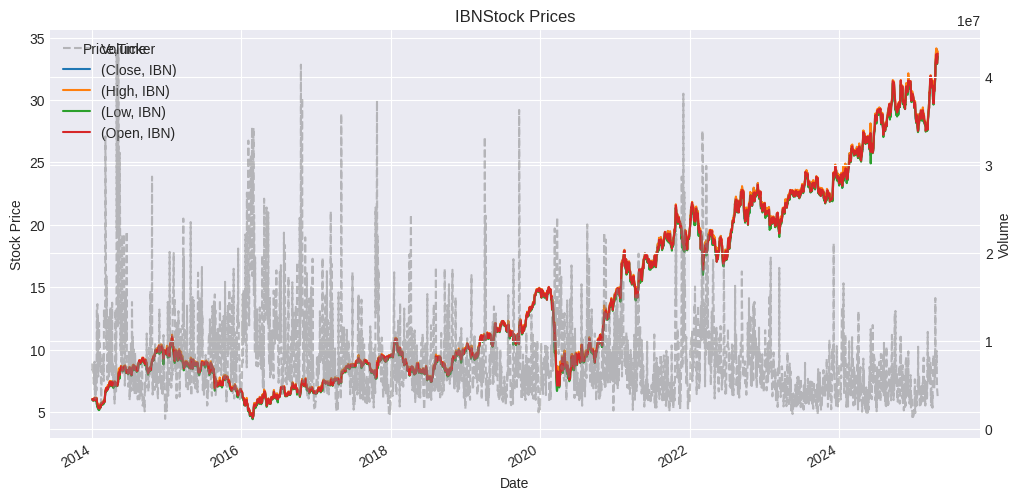

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2847 entries, 2014-01-02 to 2025-04-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2847 non-null   float64
dtypes: float64(1)
memory usage: 44.5 KB


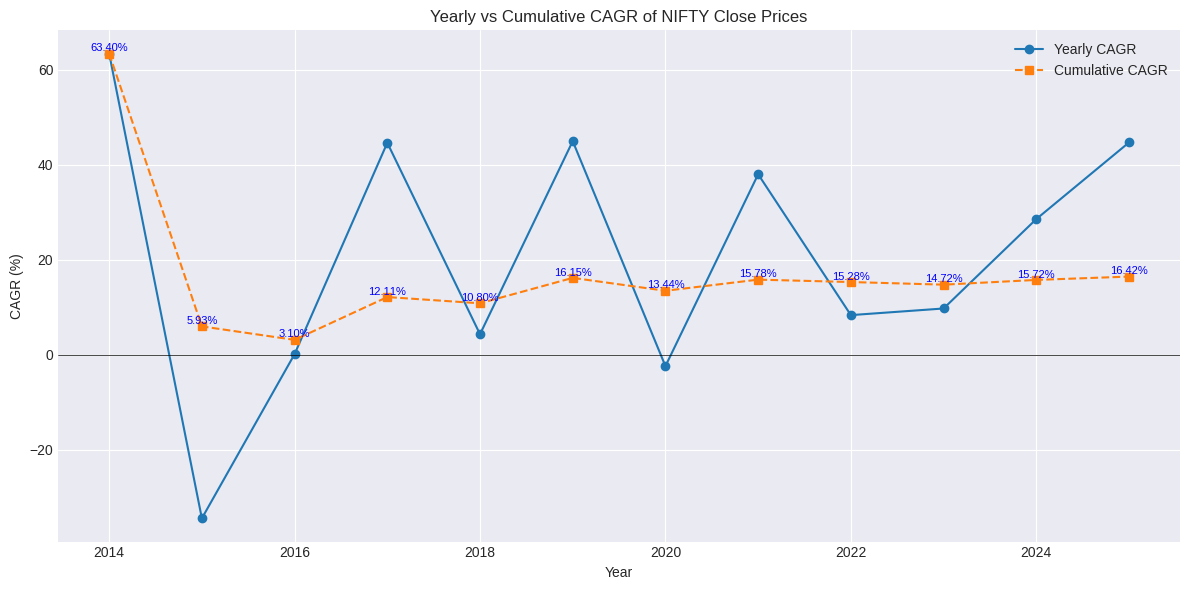

Available Expirations: ('2025-05-16', '2025-06-20', '2025-07-18', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2027-01-15')
       contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  IBN250516C00029000 2025-04-23 15:14:29+00:00    29.0       4.40  0.0  0.0   
1  IBN250516C00030000 2025-04-23 17:37:38+00:00    30.0       3.40  0.0  0.0   
2  IBN250516C00031000 2025-04-23 15:49:23+00:00    31.0       2.50  0.0  0.0   
3  IBN250516C00032000 2025-04-25 18:10:13+00:00    32.0       1.45  0.0  0.0   
4  IBN250516C00033000 2025-04-28 16:30:54+00:00    33.0       1.01  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0      60           232            0.00001        True   
1     0.0            0.0      40            54            0.00001        True   
2     0.0            0.0     250          1435            0.00001        True   
3     0.0            0.0       2           722            0

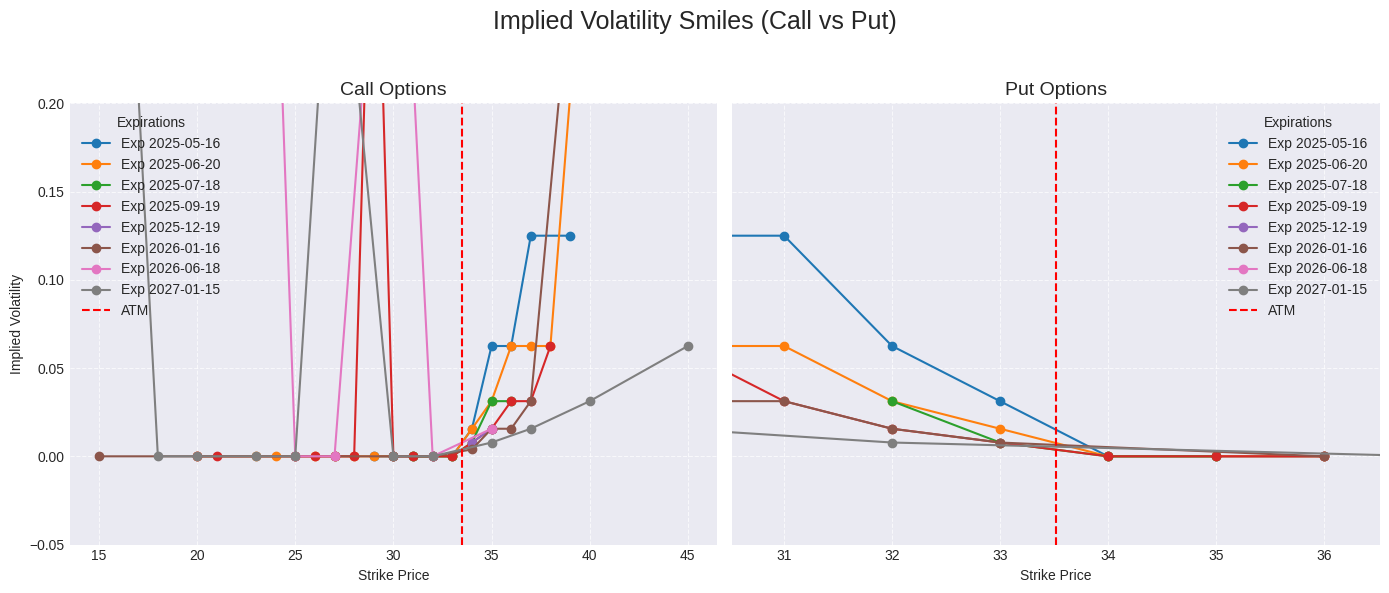

In [707]:
predictor = OptionPredictor('IBN', '2014-01-01', date.today(), 'Close', npath =100, nfuture = 252)
predictor.data_initiation()

Daily mu (sigma) = 0.05% ± 1.53%
Annual mu (sigma) = 11.54% ± 24.23%


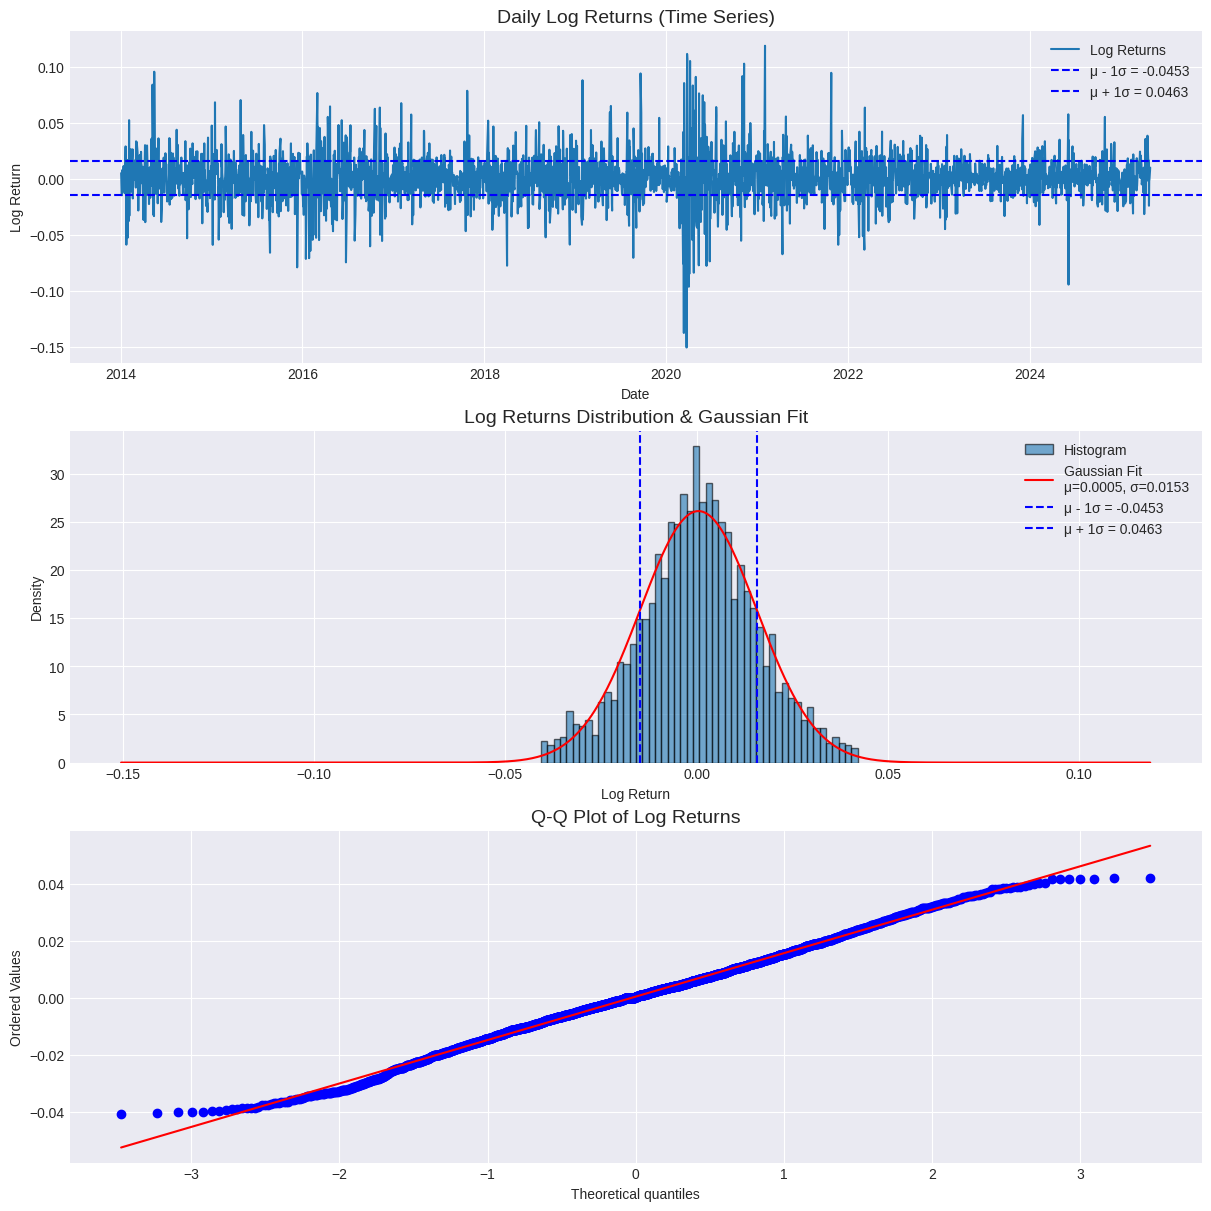

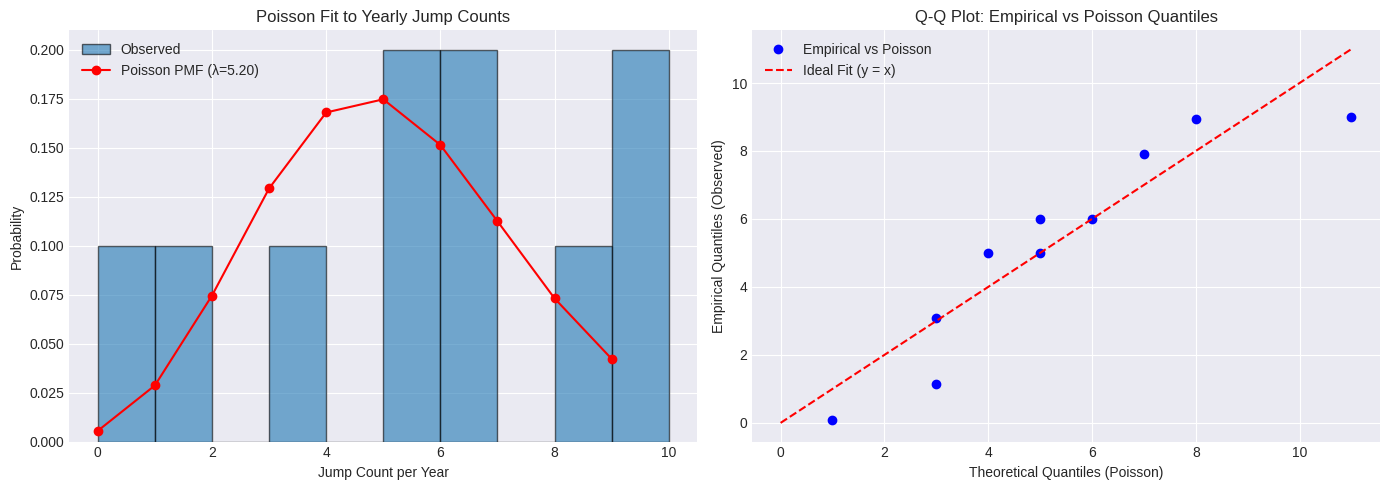

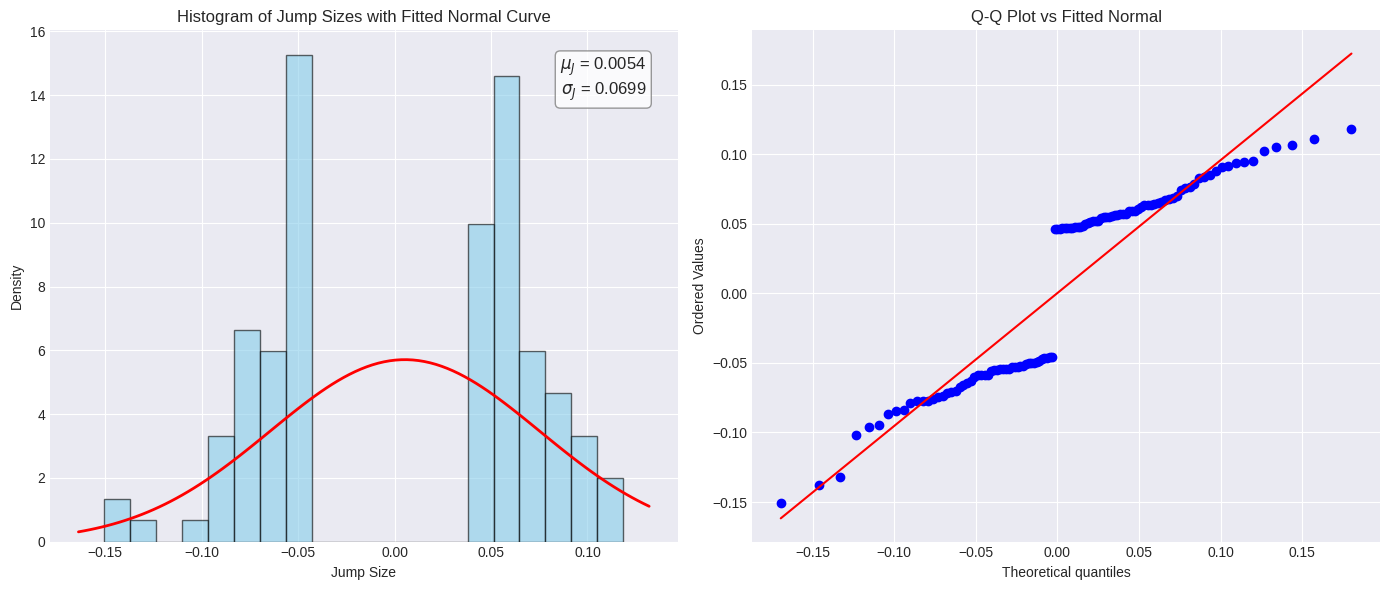

In [708]:
predictor.parameters()

Heston parameters : PSO optimization of market vs model option price

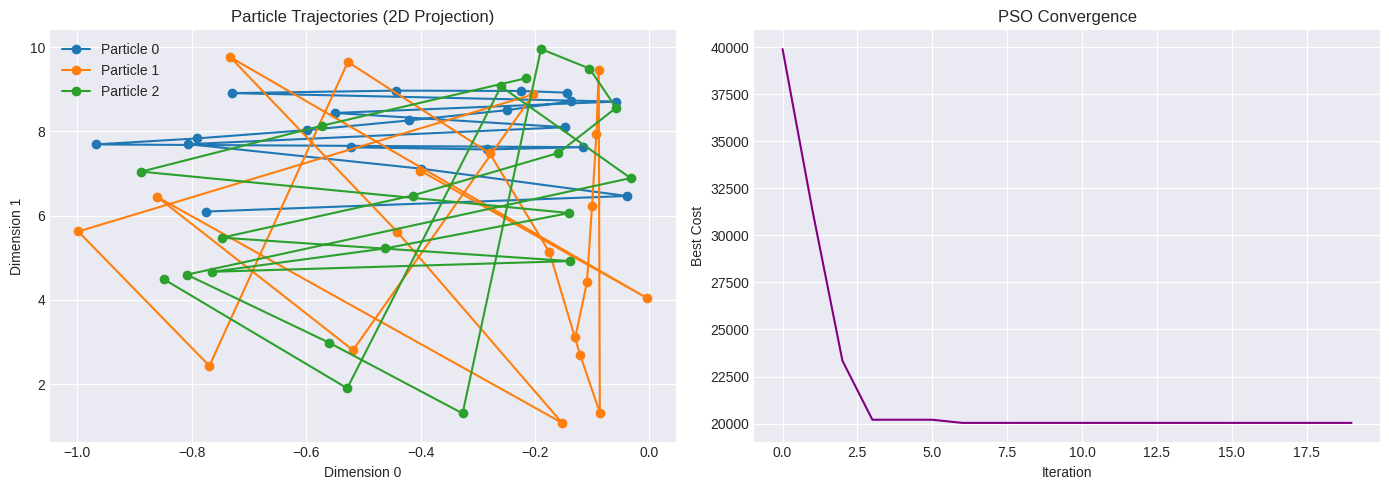

[-0.18169175  8.6122542   0.08720267  0.08334412  0.00910123]


In [709]:
predictor.parameters_heston()

Option  Pricing : Binomial Tree simulation

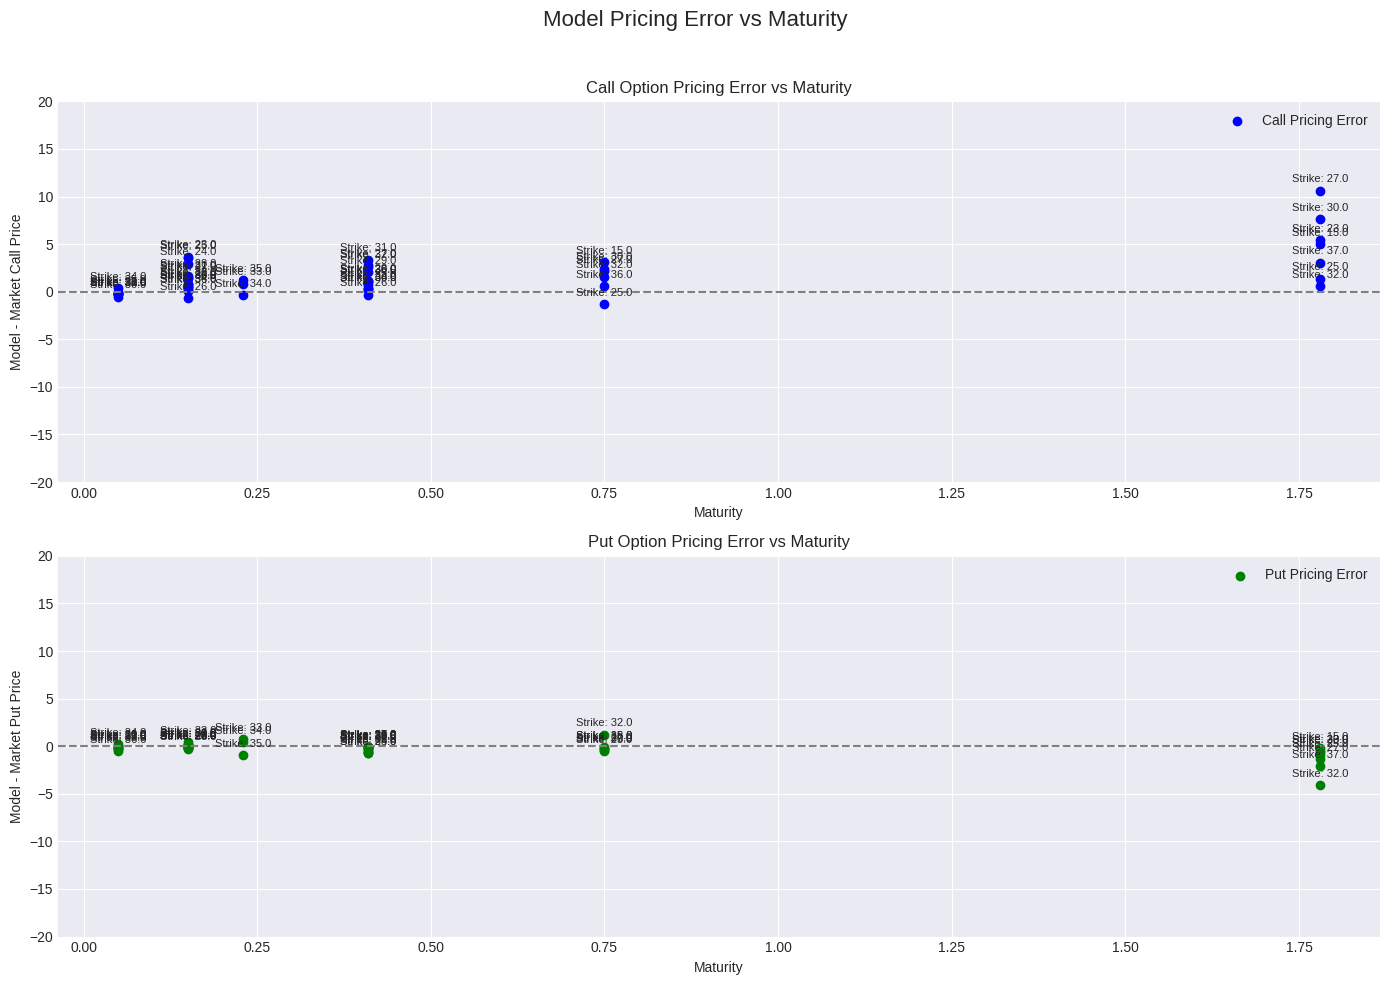

In [710]:
predictor.run_mcmc(model_type='BinomialTree')

Option  Pricing : Monte Carlo simulations

<ipython-input-701-6d14feadf592>:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)


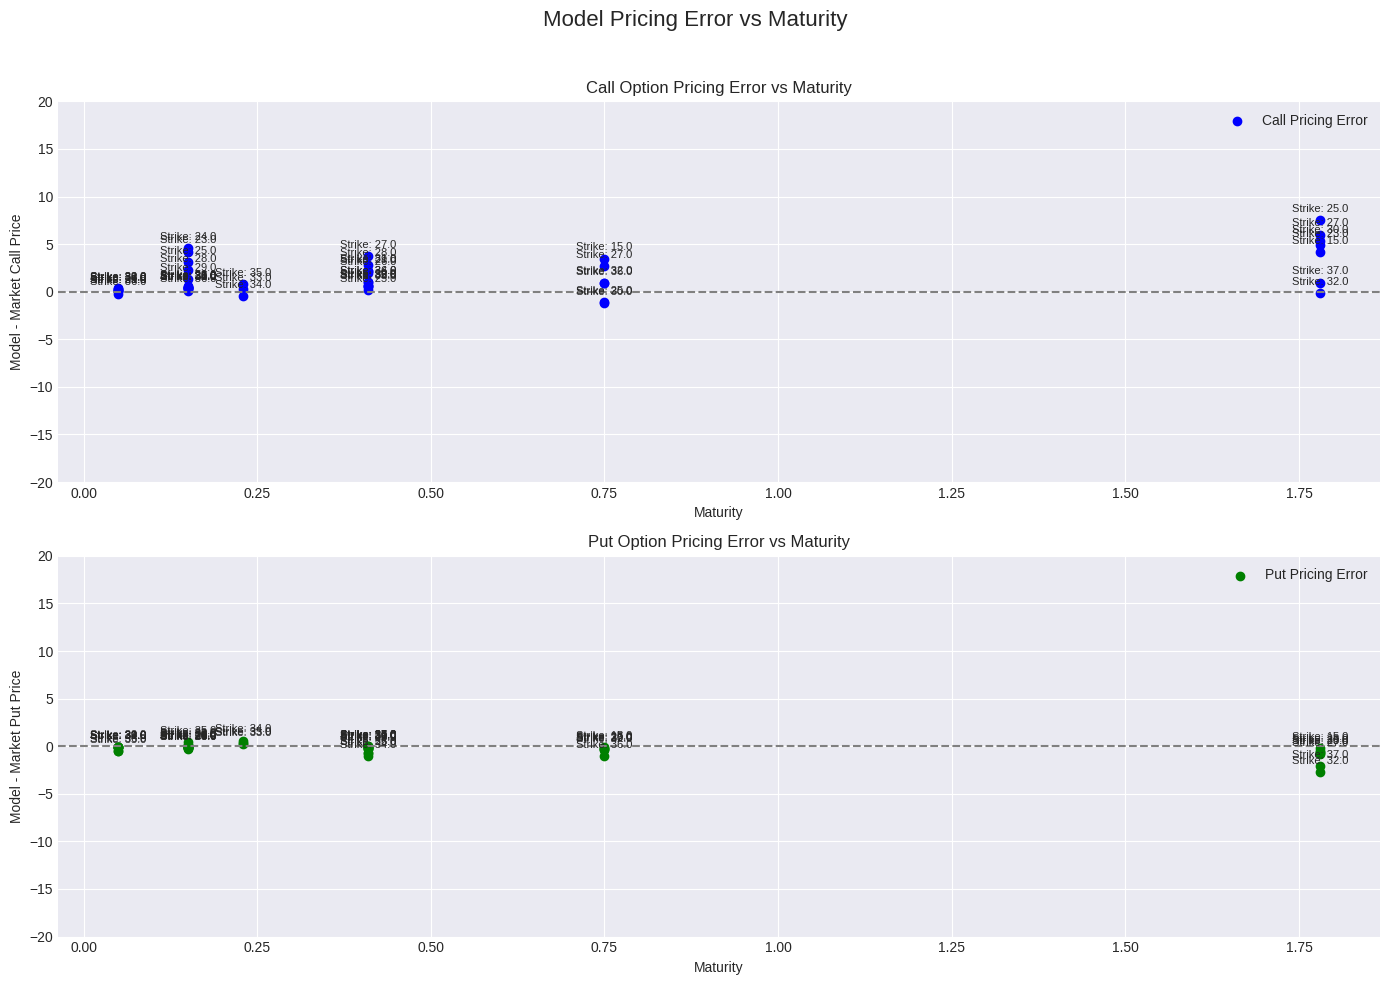

<ipython-input-701-6d14feadf592>:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)


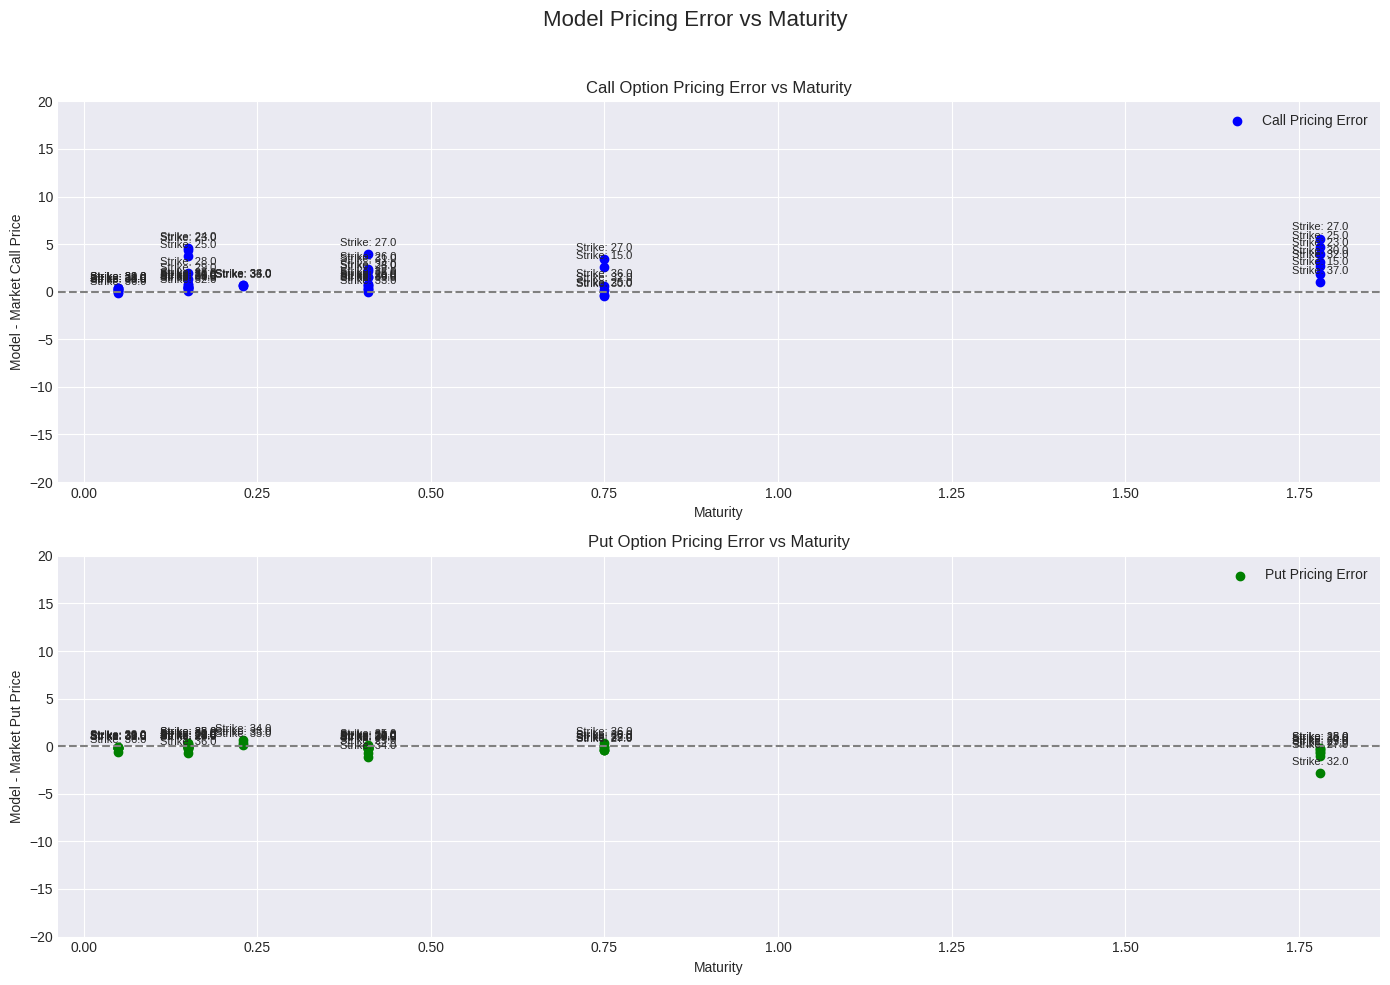

<ipython-input-701-6d14feadf592>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  volatility[ii, t] = np.maximum(volatility[ii, t-1] + kappa * (sigma_sample - volatility[ii, t-1]) * dt + sigma_sigma * np.sqrt(volatility[ii, t-1] * dt) * w2, 0)
<ipython-input-701-6d14feadf592>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * volatility[ii, t-1]) * dt + np.sqrt( volatility[ii, t-1] * dt) * w1)


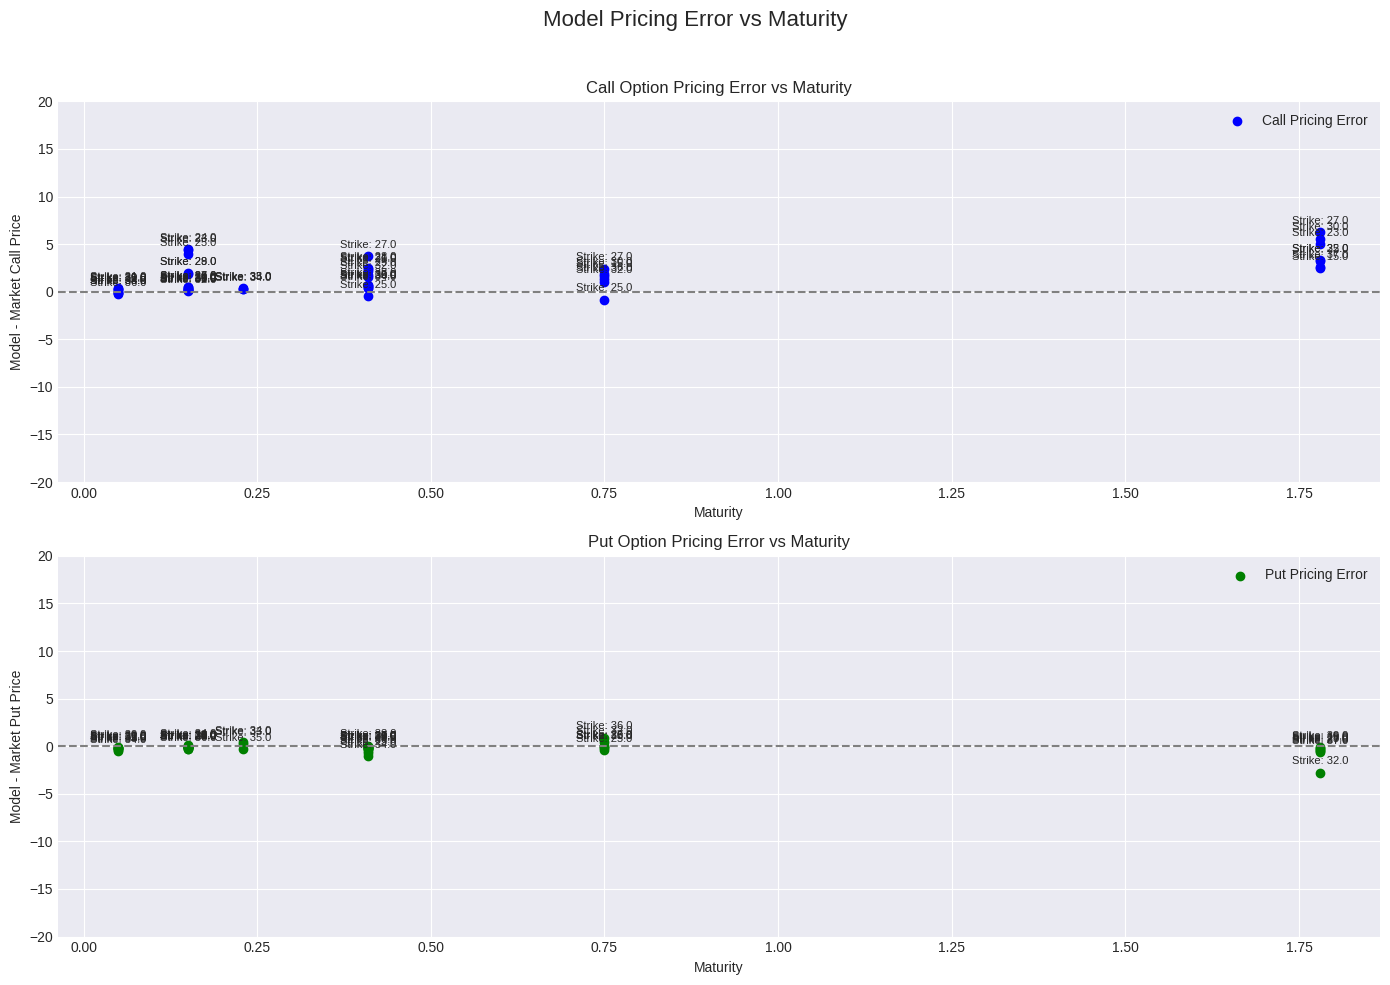

In [711]:
predictor.run_mcmc(model_type='GBM')
predictor.run_mcmc(model_type='Merton')
predictor.run_mcmc(model_type='Heston')

option  Pricing : Analytical (Semi) solution

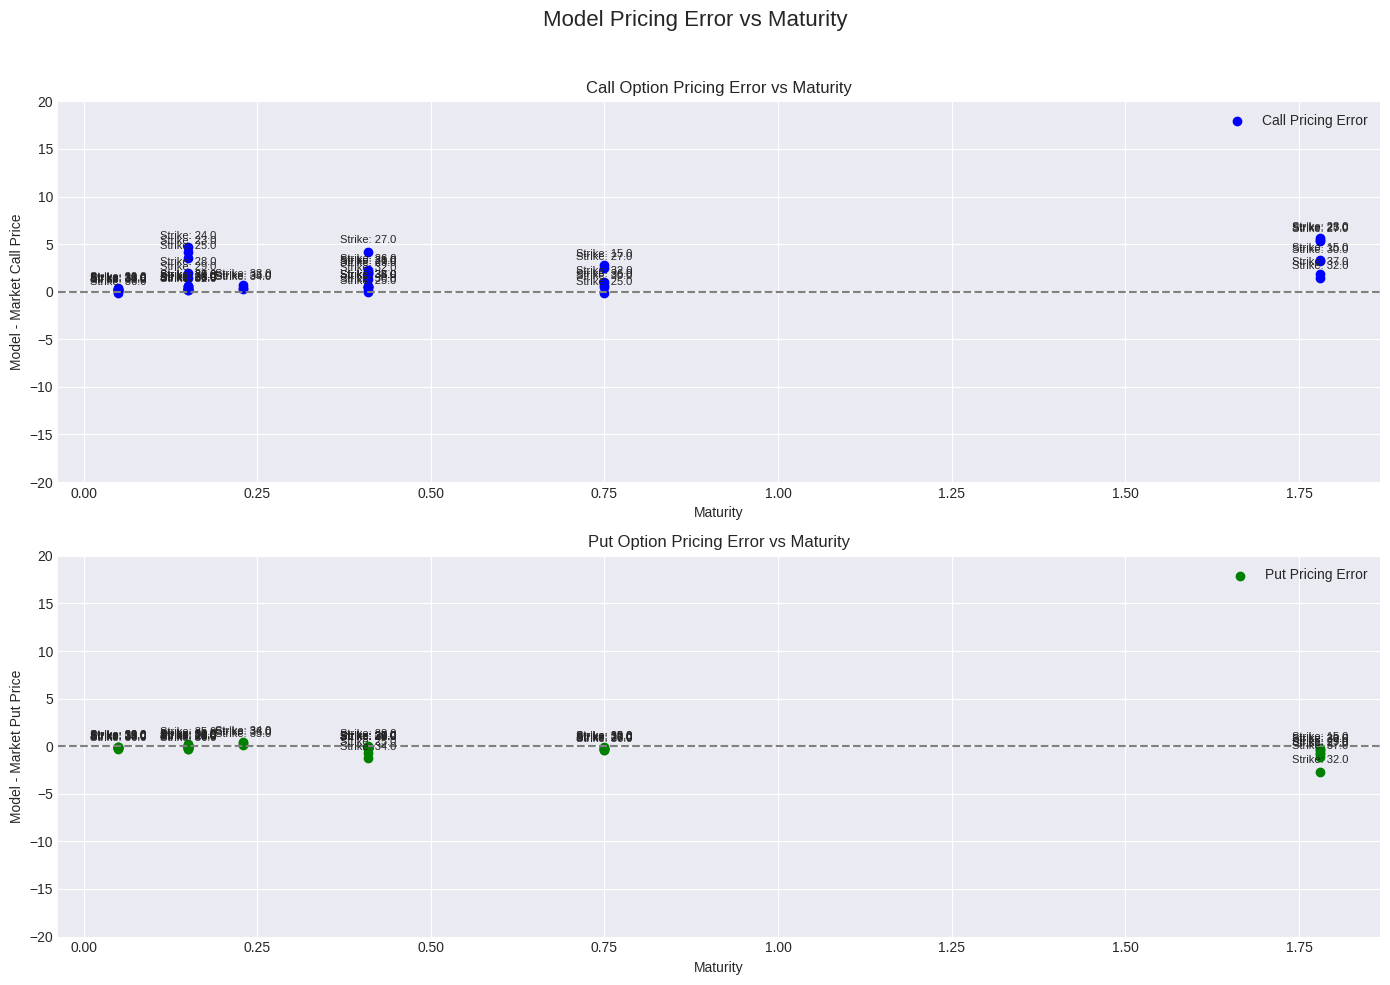

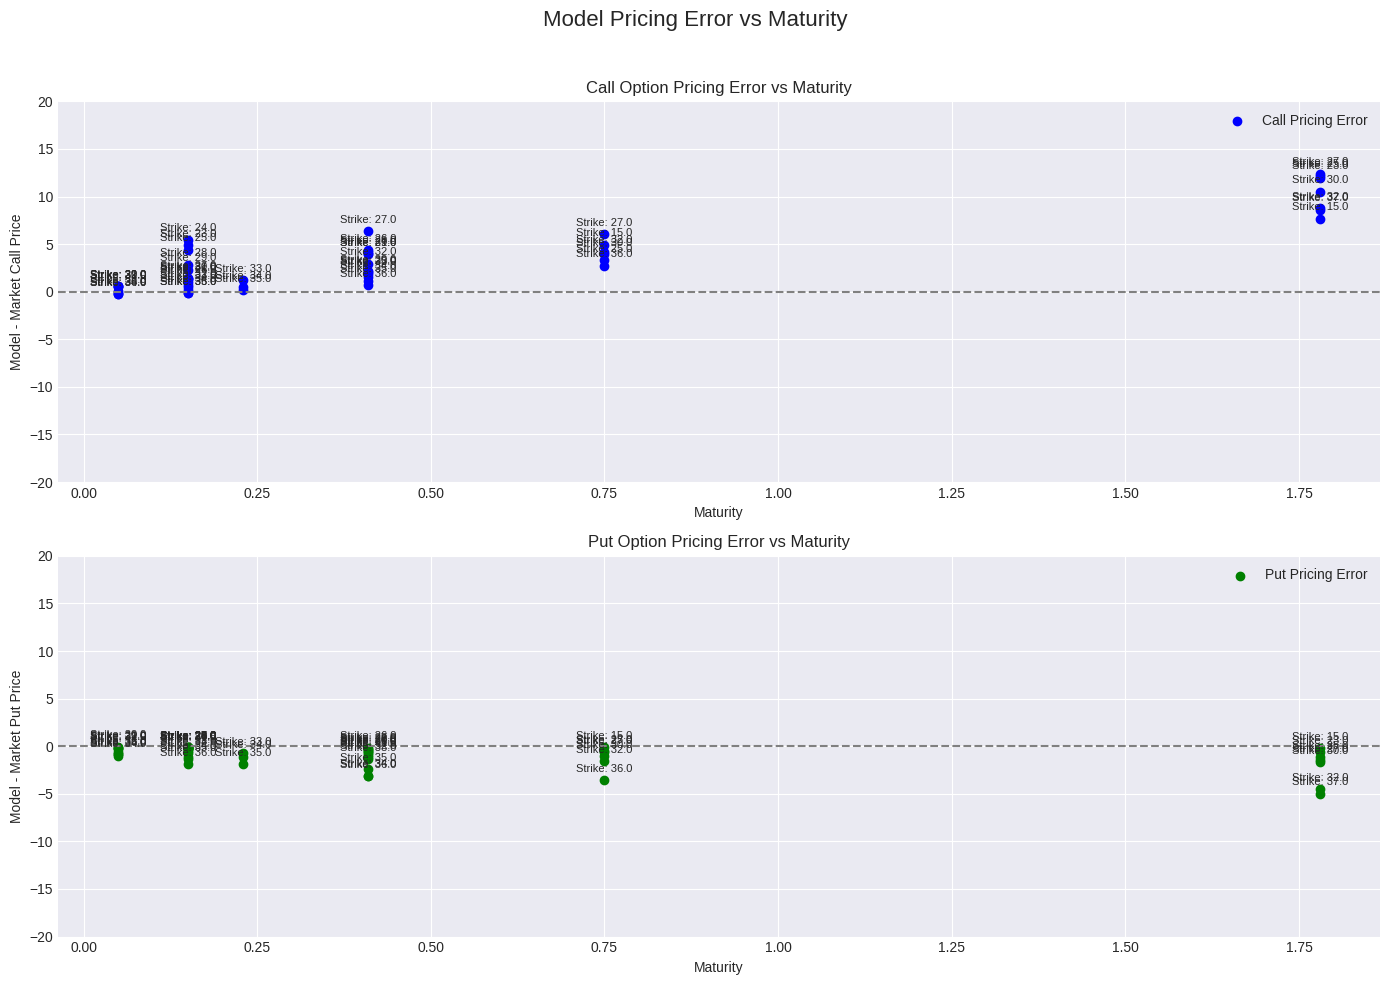

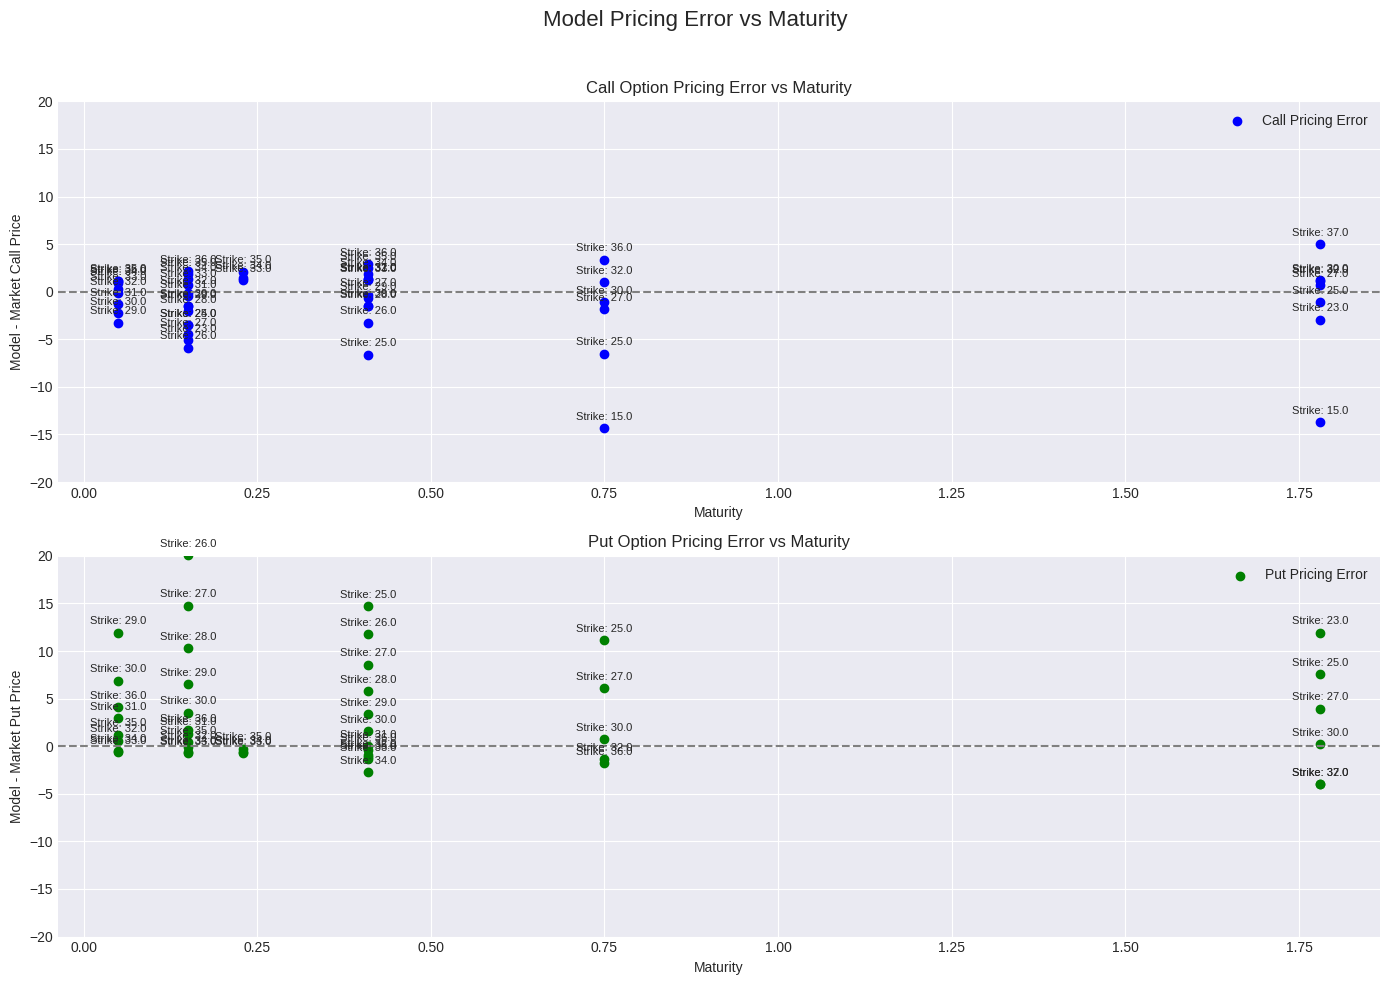

In [712]:
predictor.run_sde(model_type='GBM')
predictor.run_sde(model_type='Merton')
predictor.run_sde(model_type='Heston')